We here write a very short code to simulate the hydrogen atom driven by a time-dependent laser field. We work in spherical coordinates using a spherical harmonic expansion
\begin{equation}
\Psi(r,\theta,\phi) = \sum_{l,m} \psi_{lm}(r) Y_l^m(\theta,\phi)
\end{equation}
We assume that the electric field is $z$-polarized, so that $m$ is conserved, and use the ground state (with $m=0$) as the initial state. We thus do not need to use $m$ as an explicit index.

Everything below is in atomic units.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from jftools.short_iterative_lanczos import sesolve_lanczos
from jftools.fedvr import fedvr_grid
from laserfields import make_laserfield

In [2]:
plt.style.use('https://johannesfeist.eu/misc/jf_cb.mplstyle')

In [3]:
grid = fedvr_grid(15,np.r_[0:80.1:4])
# do not use first basis function (with grid point at r=0) to enforce boundary condition psi(0)=0
r = grid.x[1:]
# FEDVR weights
wt = grid.wt[1:]
# Kinetic energy operator
KE = -0.5*grid.dx2[1:,1:]

In [4]:
# restrict angular momentum expansion to l=0,1,2,3
ls = np.arange(0,4)
Vatom = -1/r[None,:] + (ls*(ls+1))[:,None]/(2*r[None,:]**2)

In [5]:
def H0(psi):
    """\
    apply the bare-atom Hamiltonian H0 to a wavefunction |psi>, and return |H0psi> = H0|psi>
    we assume psi to have indices [l,r]
    KE applied on psi is in principle KEpsi[l,r'] = sum_r KE[r',r] psi[l,r]
    since KE is symmetric (KE[r,r']==KE[r',r], we can write this as a matrix multiplication (operator "@" since python 3.5)
    psi[l,r] @ KE[r,r'] = sum_r psi[l,r] KE[r,r']
    on the other hand, the potential energy operator is completely diagonal, so Vpsi[l,r] = Vatom[l,r] * psi[l,r]
    this is given by the usual elementwise multiplication operator * of numpy"""
    return psi @ KE + Vatom*psi

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [6]:
from scipy.sparse import lil_matrix
rW = lil_matrix((ls.shape[0],ls.shape[0]))
# these are the angular parts of the interaction operator z = r cos(theta) expressed in the spherical harmonic basis
for ll in range(1,ls.shape[0]):
    # <ll | cos(theta) | ll-1>
    rW[ll,ll-1] = ll / np.sqrt((2*ll-1.)*(2*ll+1.))
# use a specific sparse matrix representation to easily loop over non-zero matrix elements
rW = (rW+rW.T).tocoo()

def Hz(psi,EL):
    """apply the electron-field interaction operator to a wavefunction, |Hpsi> = EL z |psi>"""
    Hpsi = 0*psi
    if EL!=0:
        for ll, ld, rWEL in zip(rW.row, rW.col, EL*rW.data):
            Hpsi[ll] += rWEL * r * psi[ld]
    return Hpsi

In [7]:
# define a scipy LinearOperator that applies H0 so we can use it in scipy-provided sparse eigenvalue solvers
# the vectors passed in there are flattened, i.e., psi[l,r] reshaped to a 1D array
from scipy.sparse.linalg import LinearOperator, eigsh
Nt = np.prod(Vatom.shape)
H0LO = LinearOperator((Nt,Nt),matvec=lambda v: H0(v.reshape(Vatom.shape)).reshape(v.shape))

In [8]:
# find the ground state of H0 using the eigsh routine of scipy.sparse.linalg
(E0,),psi0 = eigsh(H0LO,k=1,which='SA')
# reshape psi0 to be psi0[l,r] instead of a 1D array with a single combined (l,r) index
psi0 = psi0.reshape(Vatom.shape)

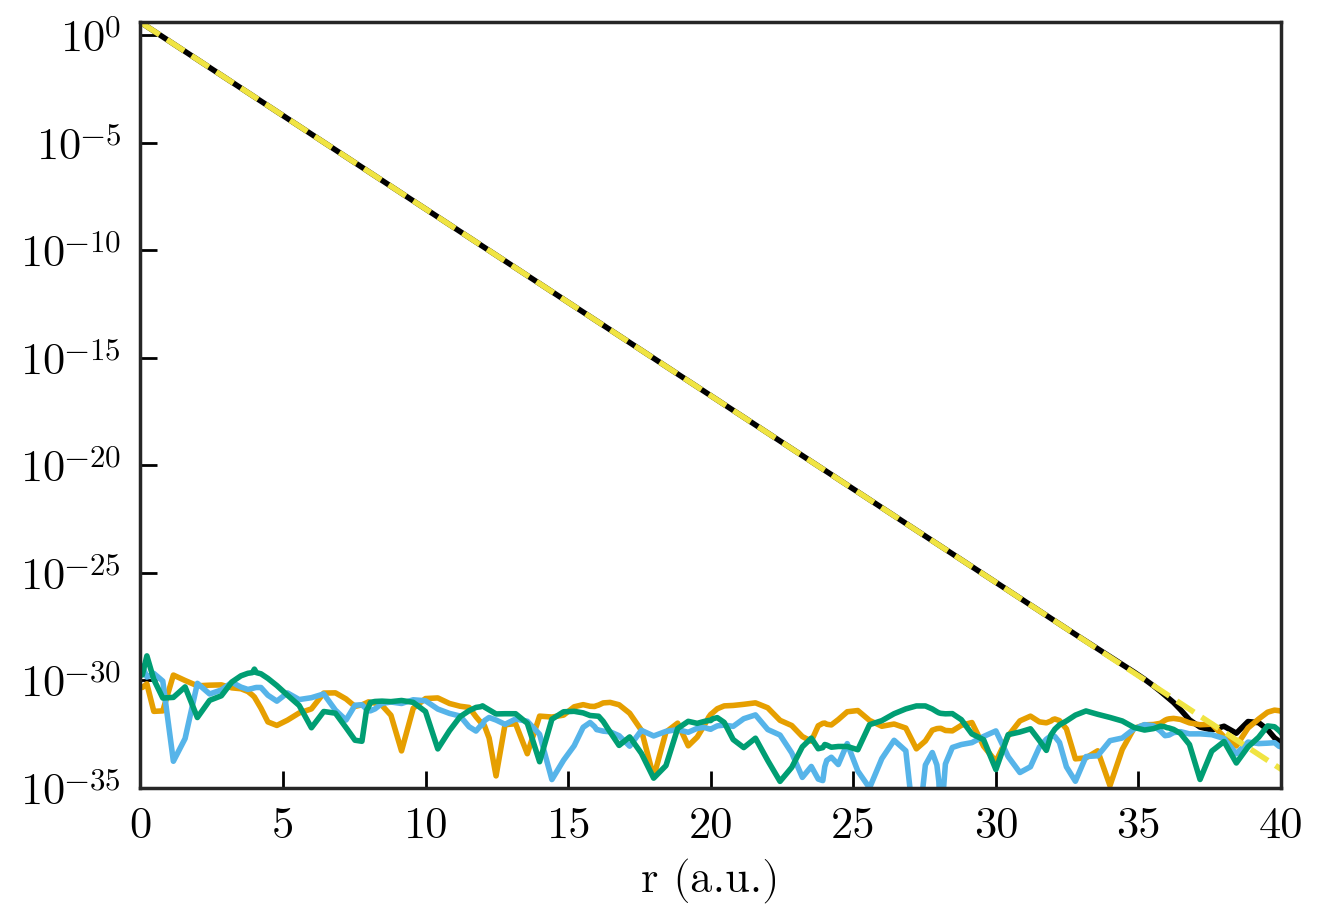

In [9]:
# plot the wavefunction and compare with the known analytical solution for hydrogen |psi(n=0,l=0,m=0)|^2 = 4*exp(-2*r)
# take into account that our psi0 is multiplied by r, and that we have FEDVR weights included
plt.plot(r,abs((psi0/(r*np.sqrt(wt))).T)**2)
plt.plot(r,4*np.exp(-2*r),'--')
plt.yscale('log')
plt.xlim(0,40)
plt.ylim(1e-35,4)
plt.xlabel('r (a.u.)');

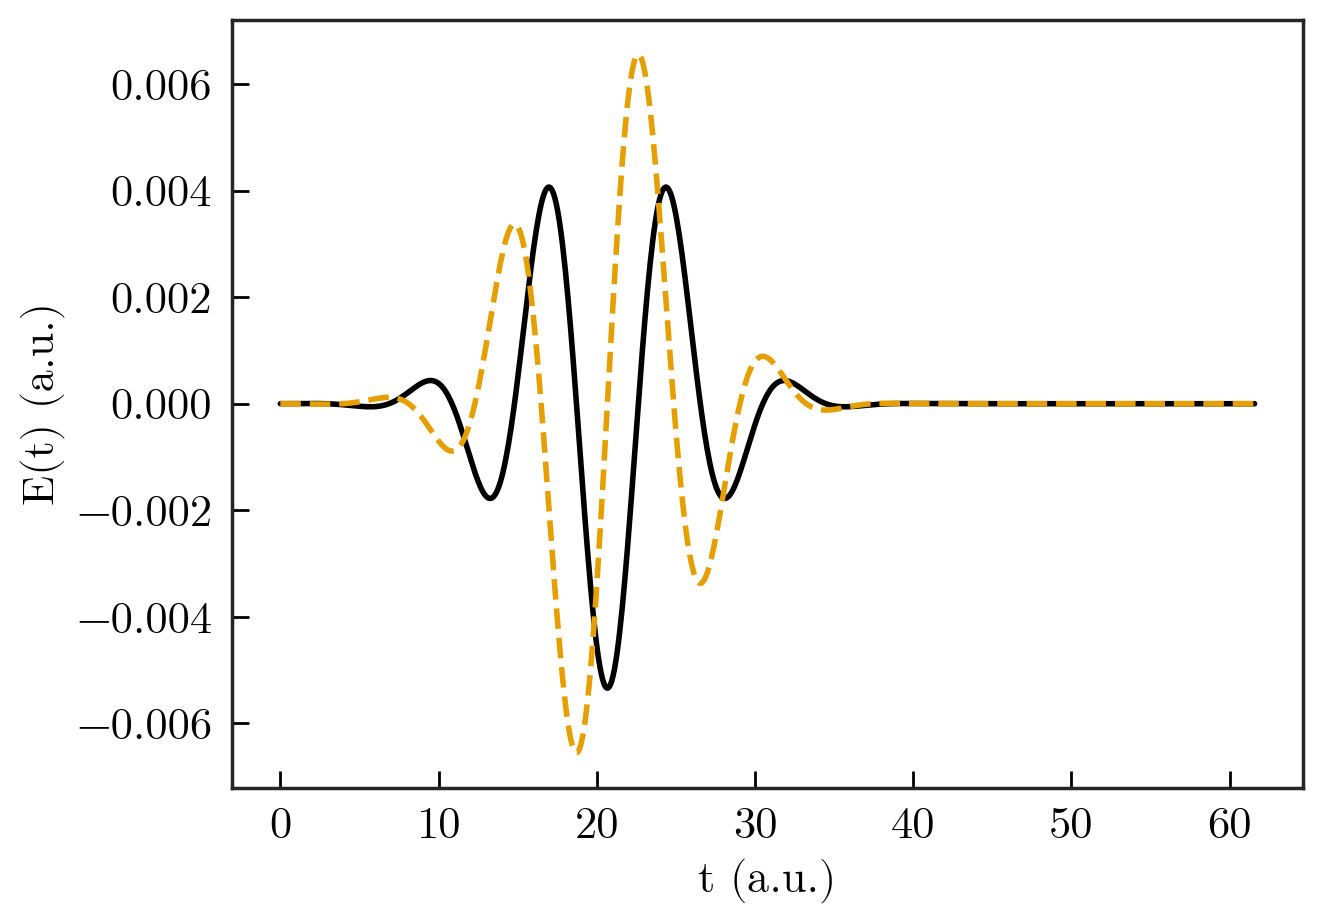

In [10]:
lf = make_laserfield(form="gaussianI",is_vecpot=True,duration_as=200,intensity_Wcm2=1e12,ω0=0.75,peak_time_as=500.)
ts = np.arange(0,lf.end_time,lf.TX/100)
plt.plot(ts,lf.E(ts))
plt.plot(ts,lf.A(ts),'--')
plt.xlabel('t (a.u.)')
plt.ylabel('E(t) (a.u.)');

In [11]:
# write a function that applies H(t) = H0 + EF(t)*z and puts the result into Hpsi
def applyH(t,psi,Hpsi):
    Hpsi[:] = H0(psi) + Hz(psi,lf(t))
    return Hpsi

In [12]:
# do short iterative lanczos time propagation
# NB: the initial state psi0 is a real array, we have to convert to complex now
psits = np.array(sesolve_lanczos(applyH,psi0.astype(complex),ts,12,1e-12,maxHT=lf.TX/50))

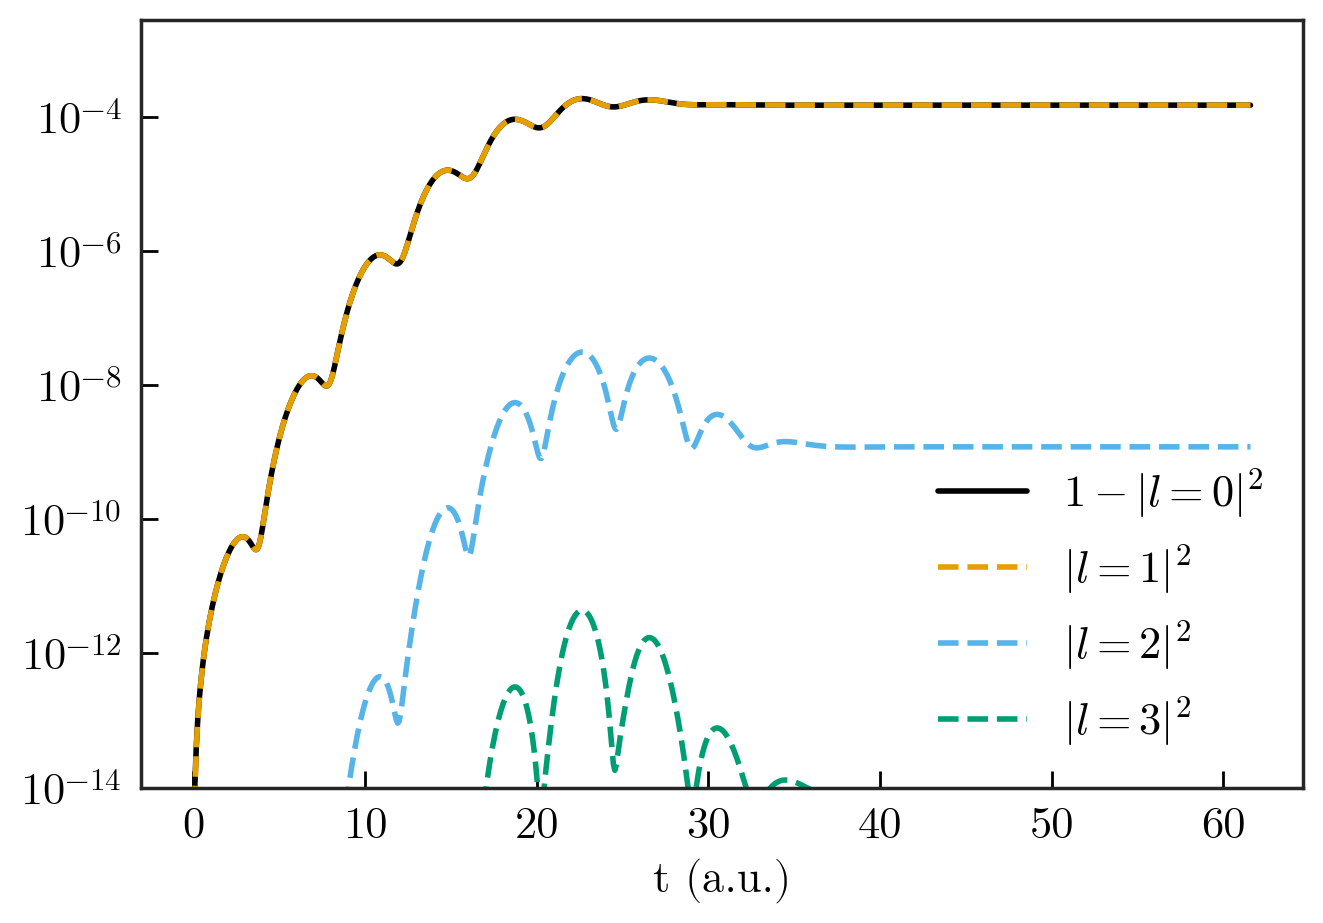

In [13]:
#plt.plot(ts,1-np.linalg.norm(psits,axis=(1,2))**2)
plt.plot(ts,1-np.linalg.norm(psits[:,0],axis=1)**2,label="$1-|l=0|^2$")
for ll in range(1,len(ls)):
    plt.plot(ts,np.linalg.norm(psits[:,ll],axis=1)**2,'--',label=f"$|l={ll}|^2$")
plt.yscale('log')
plt.ylim(1e-14,)
plt.legend();
plt.xlabel('t (a.u.)');
#plt.plot(ts,norm(psits[:,2],axis=1)**2)

In [14]:
psits.shape, ts.shape, r.shape

((736, 4, 280), (736,), (280,))

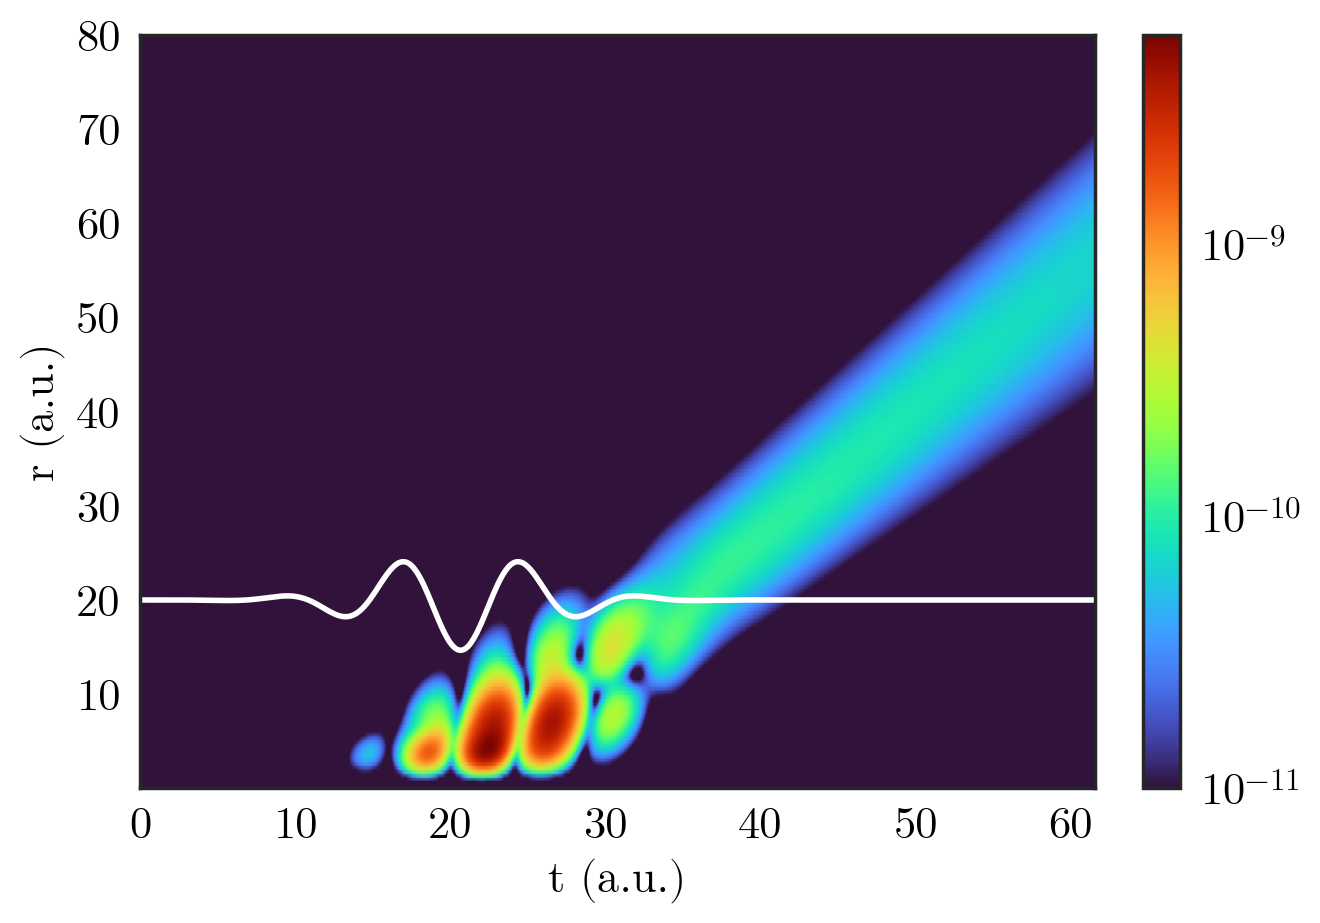

In [15]:
# plot l=2 probability density |psi[t,l=2,r]|^2
plt.pcolormesh(ts,r,abs(psits[:,2].T)**2/wt[:,None],cmap="turbo",shading='gouraud',norm=mpl.colors.LogNorm(vmin=1e-11))
plt.plot(ts,1e3*lf(ts)+20,'w')
plt.autoscale(tight=True)
#plt.axis([-15,40,0,50]);
#plt.ylim(0,30);
plt.xlabel('t (a.u.)')
plt.ylabel('r (a.u.)')
plt.colorbar();

In [16]:
# final wave function
psif = psits[-1]
# remove ground-state component
# c = <psi0|psif> (using that psi0 is real, so no complex conjugate necessary)
c0 = np.sum(psi0*psif)
print(c0,abs(c0)**2)
# |psif_exc> = |psif> - |psi0><psi0|psif> = |psif> - c0 |psi0>
psifexc = psif - c0*psi0
# check norm
assert abs(np.linalg.norm(psifexc)**2 + abs(c0)**2 - 1) < 1e-12
# two-photon excitation probability density (psif_exc[l=0 or l=2])
PTP = np.linalg.norm(psifexc[[0,2]])**2
print(PTP)

(0.8088782022470267-0.587848975420753j) 0.9998503639736107
1.8318100407421575e-09


In [17]:
# calculate eigenstates of H0 for each l by (dense) eigensystem solving of Hamiltonian
# H_l[r',r] = KE[r',r] + V_l(r) delta_{r,r'}
valvecs = [np.linalg.eigh(KE.toarray() + np.diag(Vatom[ll])) for ll in range(psif.shape[0])]

In [18]:
# convert final wave function to eigenbasis of H0
psifEB = np.empty_like(psif)
for ll in range(psif.shape[0]):
    vals,vecs = valvecs[ll]
    psifEB[ll] = vecs.T @ psif[ll]

plot l=1 component in eigenbasis, i.e., as function of energy

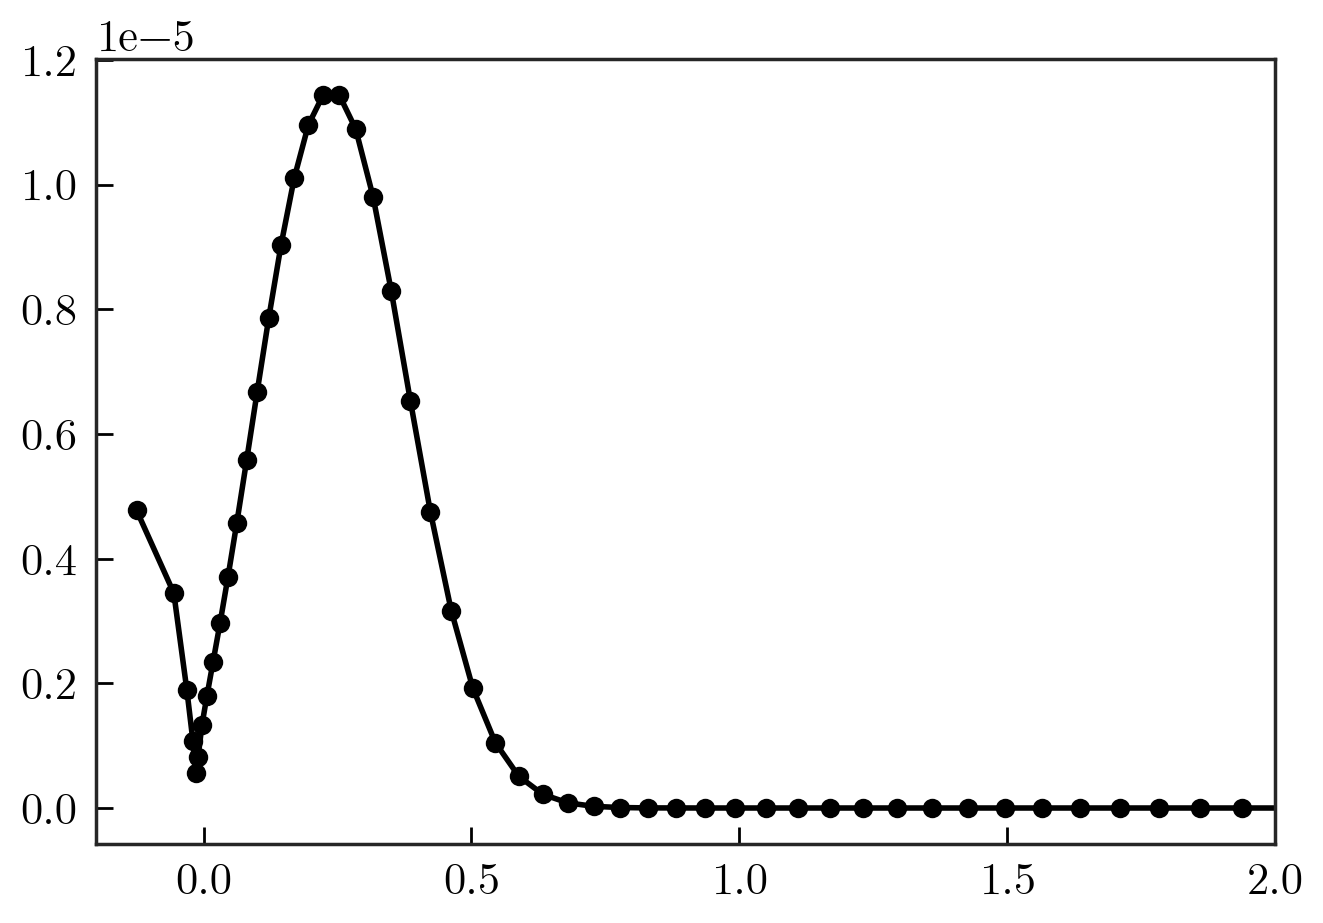

In [19]:
plt.plot(valvecs[1][0],abs(psifEB[1])**2,'o-')
plt.xlim(-0.2,2);

plot l=2 component in eigenbasis, i.e., as function of energy

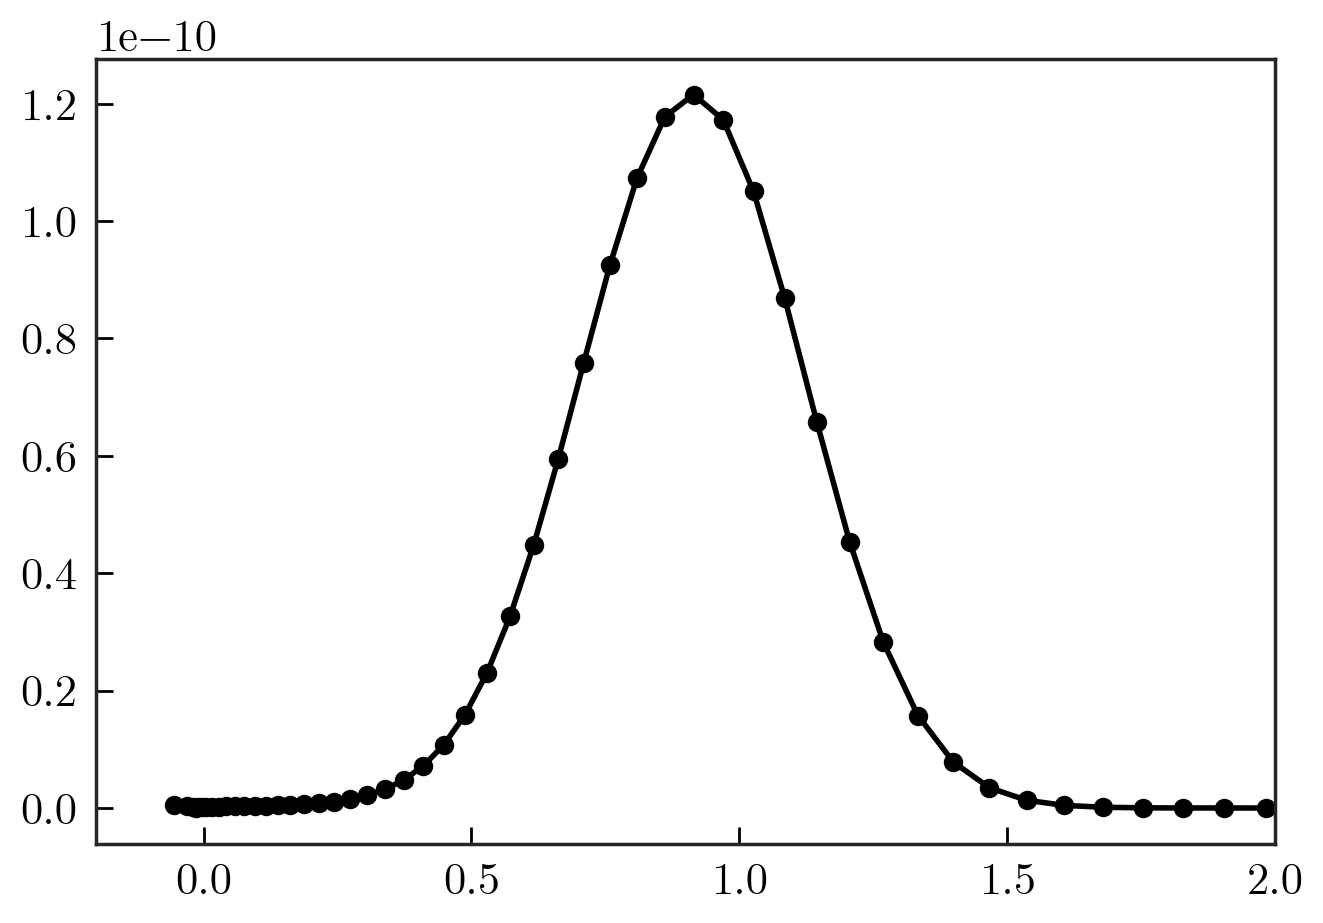

In [20]:
plt.plot(valvecs[2][0],abs(psifEB[2])**2,'o-')
plt.xlim(-0.2,2);